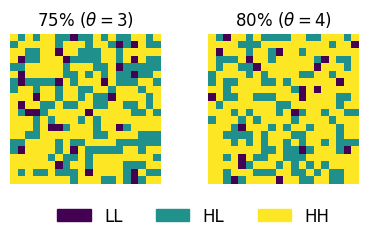

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from model import LearningModel

def plot_food_environments():
    # Create four environments
    envs = [
        LearningModel(N=0, width=20, height=20, distribute_patches='random', theta=3),
        LearningModel(N=0, width=20, height=20, distribute_patches='random', theta=4),
        #LearningModel(N=0, width=20, height=20, distribute_patches='gradient_l'),
        #LearningModel(N=0, width=20, height=20, distribute_patches='gradient_h'),
    ]
    titles = [r"75% ($\theta=3$)", r"80% ($\theta=4$)"]#, r"LL $\rightarrow$ HL", r"HH $\rightarrow$ HL"]

    fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))  # JASSS single-column width
    cmap = cm.viridis
    colors = [cmap(0/2), cmap(1/2), cmap(2/2)]  # discrete color samples

    for ax, model, title in zip(axes, envs, titles):
        data = model.grid.properties["patch_type"].data
        ax.imshow(data.T, cmap=cmap, vmin=0, vmax=2, origin="lower")
        ax.set_title(title, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Legend patches (shared)
    legend_labels = ["LL", "HL", "HH"]
    patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, legend_labels)]
    fig.legend(patches, legend_labels, loc="lower center", ncol=3, fontsize=12, frameon=False)

    plt.tight_layout(pad=0.3, rect=[0, 0.2, 0.8, 0.9])  # leave space for legend

    plt.savefig("resub/plots/food_environments.png", dpi=600, bbox_inches='tight')
    plt.savefig("resub/plots/food_environments.pdf", dpi=600, bbox_inches='tight')
    plt.show()

plot_food_environments()

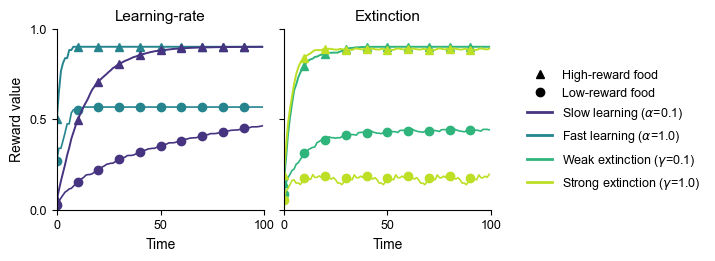

In [41]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from model import LearningModel
import matplotlib.lines as mlines

# Use Arial globally
mpl.rcParams['font.family'] = 'Arial'

def run_simulation(N=200, steps=100, learning_rate=0.4, extinction_rate=1.0):
    """Run the LearningModel for N agents and given parameters, return mean low/high values per step."""
    model = LearningModel(N=N, width=20, height=20, learning_model='RWE', epsilon=0)
    
    for a in model.agents:
        a.learning_rate = learning_rate
        a.extinction_rate = extinction_rate

    val_low, val_high = [], []

    for _ in range(steps):
        model.step()
        lows = [a.value_low for a in model.agents]
        highs = [a.value_high for a in model.agents]
        val_low.append(np.mean(lows))
        val_high.append(np.mean(highs))

    return np.array(val_low), np.array(val_high)


def plot_learning_dynamics():
    steps = 100
    time = np.arange(steps)

    # Simulations
    slow_L, slow_H = run_simulation(learning_rate=0.1, extinction_rate=0)
    fast_L, fast_H = run_simulation(learning_rate=1.0, extinction_rate=0)
    weak_L, weak_H = run_simulation(learning_rate=0.3, extinction_rate=0.1)
    strong_L, strong_H = run_simulation(learning_rate=0.3, extinction_rate=1.0)

    # Viridis colors
    cmap = plt.cm.viridis
    color_slow = cmap(0.15)
    color_fast = cmap(0.45)
    color_weak = cmap(0.65)
    color_strong = cmap(0.9)

    fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True)

    # --- Panel 1: Learning-rate ---
    axes[0].plot(time, fast_H, color=color_fast, lw=1.4, marker='^', markevery=10)
    axes[0].plot(time, fast_L, color=color_fast, lw=1.2, marker='o', markevery=10)
    axes[0].plot(time, slow_H, color=color_slow, lw=1.4, marker='^', markevery=10)
    axes[0].plot(time, slow_L, color=color_slow, lw=1.2, marker='o', markevery=10)
    axes[0].set_title('Learning-rate', fontsize=11)
    axes[0].set_xlabel('Time', fontsize=10)
    axes[0].set_ylabel('Reward value', fontsize=10)
    axes[0].set_xlim(0, steps)
    axes[0].set_ylim(0, 1)
    axes[0].set_xticks([0, 50, 100])
    axes[0].set_yticks([0, 0.5, 1.0])

    # --- Panel 2: Extinction effect ---
    axes[1].plot(time, weak_H, color=color_weak, lw=1.4, marker='^', markevery=10)
    axes[1].plot(time, weak_L, color=color_weak, lw=1.2, marker='o', markevery=10)
    axes[1].plot(time, strong_H, color=color_strong, lw=1.4, marker='^', markevery=10)
    axes[1].plot(time, strong_L, color=color_strong, lw=1.2, marker='o', markevery=10)
    axes[1].set_title('Extinction', fontsize=11)
    axes[1].set_xlabel('Time', fontsize=10)
    axes[1].set_xlim(0, steps)
    axes[1].set_xticks([0, 50, 100])
    axes[1].set_ylabel('')
    axes[1].tick_params(labelleft=False)

    # Styling
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=9)

    # --- Legend (6 items total) ---
    handles = [
        mlines.Line2D([], [], color='black', marker='^', lw=0,
                      label='High-reward food'),
        mlines.Line2D([], [], color='black', marker='o', lw=0,
                      label='Low-reward food'),
        mlines.Line2D([], [], color=color_slow, lw=2,
                      label=r'Slow learning ($\alpha$=0.1)'),
        mlines.Line2D([], [], color=color_fast, lw=2,
                      label=r'Fast learning ($\alpha$=1.0)'),
        mlines.Line2D([], [], color=color_weak, lw=2,
                      label=r'Weak extinction ($\gamma$=0.1)'),
        mlines.Line2D([], [], color=color_strong, lw=2,
                      label=r'Strong extinction ($\gamma$=1.0)'),
    ]

    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
               frameon=False, fontsize=9)

    plt.subplots_adjust(right=0.88, wspace=0.2)
    plt.tight_layout(pad=0.3)
    plt.savefig("resub/learning_dynamics.png", dpi=600, bbox_inches='tight')
    plt.savefig("resub/learning_dynamics.pdf", dpi=600, bbox_inches='tight')
    plt.show()


# Run it
plot_learning_dynamics()
